# Pre-proccessing
Imports

In [35]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import matplotlib.pyplot as plt
import graphviz
from matplotlib.patches import Circle, Rectangle, Arc

# Suppress warnings
pd.options.mode.chained_assignment = None  # default='warn'

Define the input and output files' names and locations

In [36]:
# Files definitions
datadir = 'Data'
datafilename = os.path.join(datadir, 'data.csv')
resultsfilename = os.path.join(datadir, 'results.csv')
fullresultsfilename = os.path.join(datadir, 'results_full.csv')

Load the data and sort it chronologically

In [37]:
# Load data
rawdata = pd.read_csv(datafilename)

# Sort chronologically and redefine the index (for leakage handling)
rawdata['date'] = pd.to_datetime(rawdata['game_date'])
rawdata.sort_values(['date', 'game_event_id'],
                    ascending = True, inplace = True)
rawdata.drop('date', axis = 1, inplace = True)
rawdata['index'] = range(len(rawdata))
rawdata.set_index('index', drop = True, inplace = True)


Define variables' types

In [38]:
# Define variables definitions

# Categorical variables
cat_vars = ['action_type', 'combined_shot_type', 'period', 'season',
            'shot_type', 'shot_zone_area', 'shot_zone_basic',
            'shot_zone_range', 'opponent']

# Irrelevant variables
drop_vars = ['game_id', 'lat', 'lon', 'team_id',
             'team_name', 'matchup']

# Date variables
date_vars = ['game_date']

# Output variable
pred_var = 'shot_made_flag'

# Prediction's columns
pred_cols = ['shot_id', 'shot_made_flag']

Generate new variables

In [39]:
# new variables

# home or not?
rawdata['home'] = rawdata['matchup'].apply(
		lambda x: 1 if (x.find('@') < 0) else 0)

rawdata['seconds_from_period_end'] = 60*rawdata['minutes_remaining'] +\
                                     rawdata['seconds_remaining']
rawdata['seconds_from_period_start'] = 60*(11 - rawdata['minutes_remaining']) +\
                                       (60 - rawdata['seconds_remaining'])
rawdata['seconds_from_game_start'] = (rawdata['period'] <= 4).astype(int) *\
                                     (rawdata['period']-1)*12*60 +\
                                     (rawdata['period'] > 4).astype(int) *\
                                     ((rawdata['period']-4)*5*60 + 3*12*60) +\
                                     rawdata['seconds_from_period_start']
rawdata['period_last_5_seconds'] = (rawdata['seconds_from_period_end'] < 6).\
	astype(int)
rawdata['game_last_5_seconds'] = rawdata['period_last_5_seconds'] *\
                                 (rawdata['period'] > 3).astype(int)
rawdata['angle'] = np.arctan2(rawdata['loc_x'], rawdata['loc_y'])


Handle date and categorical variables

In [40]:
for var in date_vars:
	# Convert the date variable to month, week no. and week day, and treat
	# them as categorical features
	datevar = pd.to_datetime(rawdata[var], format = "%Y-%m-%d")
	rawdata[var + '_month'] = datevar.dt.month
	rawdata[var + '_month_x'] = np.sin(2 * np.pi * rawdata[var + '_month'] / 12)
	rawdata[var + '_month_y'] = np.cos(2 * np.pi * rawdata[var + '_month'] / 12)
	cat_vars.append(var + '_month')
	rawdata[var + '_weekday'] = datevar.dt.dayofweek
	rawdata[var + '_weekday_x'] = np.sin(
			2 * np.pi * rawdata[var + '_weekday'] / 7)
	rawdata[var + '_weekday_y'] = np.cos(
		2 * np.pi * rawdata[var + '_weekday'] / 7)
	cat_vars.append(var + '_weekday')

for var in cat_vars:
	# Replace the categorical feature with N binary features
	cat_list = pd.get_dummies(rawdata[var], prefix = var, prefix_sep = ': ')
	data1 = rawdata.join(cat_list)  # adds data columns to data
	rawdata = data1

Filter only relevant variables and split data columns

In [41]:
data_vars = rawdata.columns.values.tolist()
to_keep = [i for i in data_vars if (i not in cat_vars and
                                    i not in drop_vars and
                                    i not in date_vars)]
rawdata = rawdata[to_keep]  # generating a new dataset, overriding old one.

X_cols = [i for i in rawdata.columns if i not in pred_var]  # predict by cols
Y_cols = [pred_var]

# Prepare the training and evaluation data
Split the data into training and evaluation sets

In [42]:
# Split data
test_rows = pd.isnull(rawdata[pred_var])    # gives indices of rows to predict
traindata = rawdata[~test_rows]
evaldata = rawdata[test_rows]

# Prepare the training data
X0 = traindata[X_cols]
Y0 = np.ravel(traindata[Y_cols])

# Feature selection
Plot the features' rankings according to Recursive Feature Elimination

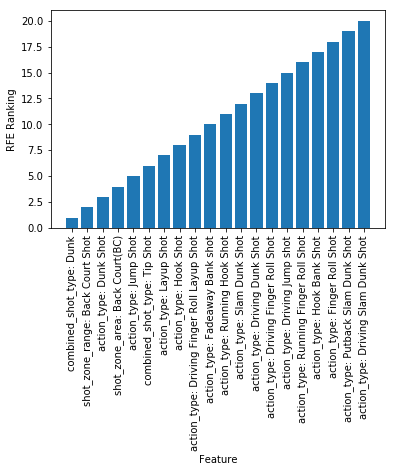

In [43]:
# Plot RFE rankings
lr = LogisticRegression()
rfe = RFE(lr, 1)
rfe = rfe.fit(X0, Y0)
feature_df = pd.DataFrame(rfe.ranking_, index = X_cols, columns = ["ranking"])
feature_df.sort_values("ranking", inplace = True)
feature_df = feature_df.head(20)
plt.figure()
x_axis = np.arange(len(feature_df))
plt.bar(x_axis, feature_df["ranking"])
plt.xticks(x_axis, feature_df.index, rotation = 'vertical')
plt.xlabel("Feature")
plt.ylabel("RFE Ranking")
plt.show()

Use Recursive Feature Elimination to find the 10 most important features

In [44]:
# Choose a subset of features by recursive features elimination
lr = LogisticRegression()
n_features = 10
rfe = RFE(lr, n_features)  # chooses the best N features from which to do LR
rfe.fit(X0, Y0)
X_cols_rfe = [X_cols[i] for i in range(len(X_cols)) if rfe.get_support()[i]]
print('RFE chosen features: ', X_cols_rfe)
print(len(X_cols_rfe))

RFE chosen features:  ['action_type: Driving Finger Roll Layup Shot', 'action_type: Dunk Shot', 'action_type: Fadeaway Bank shot', 'action_type: Hook Shot', 'action_type: Jump Shot', 'action_type: Layup Shot', 'combined_shot_type: Dunk', 'combined_shot_type: Tip Shot', 'shot_zone_area: Back Court(BC)', 'shot_zone_range: Back Court Shot']
10


Use LDA to find the optimal projection of the data to 1D

In [45]:
# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X0, Y0)
X0_lda = lda.transform(X0)

C:\Users\Aviv\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Build a regression tree

In [46]:
# Regression tree
dtr_mid = 0.005
dtr = DecisionTreeRegressor(min_impurity_decrease = dtr_mid)
dtr.fit(X0, Y0)
X0_dtr = dtr.predict(X0)

Visualize the regression tree

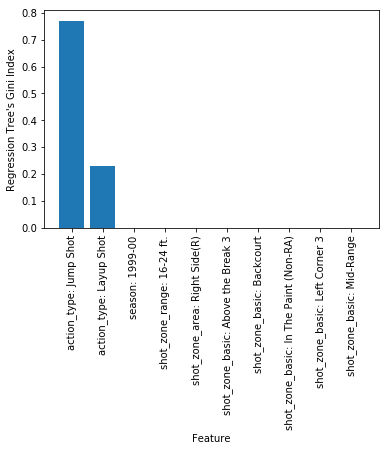

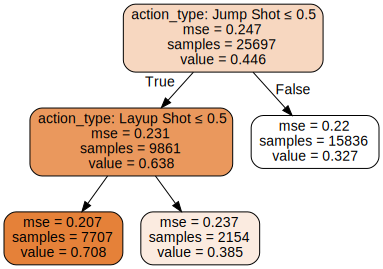

In [47]:
# Plot Regression Tree features' importances
feature_df = pd.DataFrame(dtr.feature_importances_,
                          index = X_cols,
                          columns = ["importance"])
feature_df.sort_values("importance", ascending = False, inplace = True)
feature_df = feature_df.head(10)
plt.figure()
x_axis = np.arange(len(feature_df))
plt.bar(x_axis, feature_df["importance"])
plt.xticks(x_axis, feature_df.index, rotation = 'vertical')
plt.xlabel("Feature")
plt.ylabel("Regression Tree's Gini Index")
plt.show()
dot_data = export_graphviz(dtr, out_file = None, feature_names = X_cols,
                           filled = True, rounded = True,
                           special_characters = True)
graph = graphviz.Source(dot_data, format = 'png')
graph

Filter the features found by RFE, and add the LDA projection and the regression tree's prediction as additional features

In [48]:
# Filter columns
# unique is just to not calculate one param multiple times
X_cols_f = X_cols_rfe
print('Final chosen features: ', X_cols_f)
print(len(X_cols_f))
X0 = X0[X_cols_f]
X0.loc[:, 'LDA'] = X0_lda		# adding value of a single LDA dim
X0.loc[:, 'DTR'] = X0_dtr		# adding value of DTR prediction

Final chosen features:  ['action_type: Driving Finger Roll Layup Shot', 'action_type: Dunk Shot', 'action_type: Fadeaway Bank shot', 'action_type: Hook Shot', 'action_type: Jump Shot', 'action_type: Layup Shot', 'combined_shot_type: Dunk', 'combined_shot_type: Tip Shot', 'shot_zone_area: Back Court(BC)', 'shot_zone_range: Back Court Shot']
10


# Test the model
Use logistic regression for prediction, and display the cross-validation score

In [49]:
# Test the model
lr = LogisticRegression()
scores = -cross_val_score(lr, X0, Y0, cv = 10, scoring = 'neg_log_loss')
print('CV log-loss: ', np.mean(scores), '+/-', np.std(scores))

CV log-loss:  0.603837656249 +/- 0.0100247304665


# Generate predictions
Use quick_test = False to handle leakage correctly

In [50]:
# Set this to True to ignore leakage and get a faster code
quick_test = False

# For test only - Leakage problem
if quick_test: 	# (with leakage, quick and dirty)
	
	# Fit the model
	lr = LogisticRegression()
	lr.fit(X0, Y0)  # trains on training data. Here the flesh lies.
	
	# Generate the model's prediction
	Xlda = lda.transform(evaldata[X_cols])
	Xdtr = dtr.predict(evaldata[X_cols])
	X = evaldata[X_cols_f]
	X.loc[:, 'LDA'] = Xlda
	X.loc[:, 'DTR'] = Xdtr
	Y = lr.predict_proba(X)  # without _proba , this would have given 0/1
	evaldata.loc[:, pred_var] = Y[:, 1]

# Leakage handle
else:		# without leakage
	
	c = 0
	C = len(evaldata)
	for t in evaldata.index:
		
		# Filter only past data
		ind = traindata.index
		ind_t = ind[ind < t]
		if len(ind_t) == 0:		# if row picked is first
			evaldata.loc[t, pred_var] = 0.5     # For the first shot, just guess
			continue
		Xt = traindata.loc[ind_t, X_cols_f]
		Yt = np.ravel(traindata.loc[ind_t, Y_cols])
		
		# Fit the model
		lda = LinearDiscriminantAnalysis()
		lda.fit(traindata.loc[ind_t, X_cols], Yt)
		Xt.loc[:, 'LDA'] = lda.transform(traindata.loc[ind_t, X_cols])
		dtr = DecisionTreeRegressor(min_impurity_decrease = dtr_mid)
		dtr.fit(traindata.loc[ind_t, X_cols], Yt)
		Xt.loc[:, 'DTR'] = dtr.predict(traindata.loc[ind_t, X_cols])
		lr = LogisticRegression()
		lr.fit(Xt, Yt)  # trains on training data. Here the flesh lies.

		# Generate the model's prediction
		X = evaldata.loc[[t], X_cols_f]
		# using the LDA axis found, generate and add "LDA value"
		X.loc[:, 'LDA'] = lda.transform(evaldata.loc[[t], X_cols])
		X.loc[:, 'DTR'] = dtr.predict(evaldata.loc[[t], X_cols])
		Y = lr.predict_proba(X)     # without _proba , this would have given 0/1
		evaldata.loc[t, pred_var] = Y[0, 1]
		
		# Display progress
		c = c + 1
		print(t, ': ', c, '/', C)

5 :  1 / 5000
7 :  2 / 5000


C:\Users\Aviv\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


24 :  3 / 5000
25 :  4 / 5000
28 :  5 / 5000
32 :  6 / 5000
35 :  7 / 5000
37 :  8 / 5000
47 :  9 / 5000
49 :  10 / 5000
53 :  11 / 5000
63 :  12 / 5000
64 :  13 / 5000
66 :  14 / 5000
70 :  15 / 5000
73 :  16 / 5000
79 :  17 / 5000
86 :  18 / 5000
92 :  19 / 5000
94 :  20 / 5000
109 :  21 / 5000
126 :  22 / 5000
129 :  23 / 5000
133 :  24 / 5000
136 :  25 / 5000
140 :  26 / 5000
147 :  27 / 5000
149 :  28 / 5000
151 :  29 / 5000
155 :  30 / 5000
156 :  31 / 5000
161 :  32 / 5000
162 :  33 / 5000
165 :  34 / 5000
169 :  35 / 5000
173 :  36 / 5000
175 :  37 / 5000
188 :  38 / 5000
192 :  39 / 5000
195 :  40 / 5000
201 :  41 / 5000
205 :  42 / 5000
215 :  43 / 5000
220 :  44 / 5000
222 :  45 / 5000
224 :  46 / 5000
227 :  47 / 5000
234 :  48 / 5000
239 :  49 / 5000
240 :  50 / 5000
245 :  51 / 5000
252 :  52 / 5000
257 :  53 / 5000
263 :  54 / 5000
269 :  55 / 5000
271 :  56 / 5000
273 :  57 / 5000
277 :  58 / 5000
280 :  59 / 5000
283 :  60 / 5000
286 :  61 / 5000
287 :  62 / 5000
307 :

2495 :  451 / 5000
2502 :  452 / 5000
2505 :  453 / 5000
2515 :  454 / 5000
2518 :  455 / 5000
2519 :  456 / 5000
2520 :  457 / 5000
2526 :  458 / 5000
2540 :  459 / 5000
2548 :  460 / 5000
2549 :  461 / 5000
2550 :  462 / 5000
2551 :  463 / 5000
2562 :  464 / 5000
2570 :  465 / 5000
2603 :  466 / 5000
2612 :  467 / 5000
2613 :  468 / 5000
2614 :  469 / 5000
2617 :  470 / 5000
2630 :  471 / 5000
2636 :  472 / 5000
2649 :  473 / 5000
2651 :  474 / 5000
2655 :  475 / 5000
2657 :  476 / 5000
2659 :  477 / 5000
2689 :  478 / 5000
2701 :  479 / 5000
2704 :  480 / 5000
2710 :  481 / 5000
2711 :  482 / 5000
2717 :  483 / 5000
2720 :  484 / 5000
2722 :  485 / 5000
2732 :  486 / 5000
2737 :  487 / 5000
2739 :  488 / 5000
2740 :  489 / 5000
2741 :  490 / 5000
2746 :  491 / 5000
2747 :  492 / 5000
2748 :  493 / 5000
2750 :  494 / 5000
2753 :  495 / 5000
2757 :  496 / 5000
2760 :  497 / 5000
2770 :  498 / 5000
2771 :  499 / 5000
2772 :  500 / 5000
2778 :  501 / 5000
2780 :  502 / 5000
2783 :  503 

5101 :  883 / 5000
5102 :  884 / 5000
5105 :  885 / 5000
5114 :  886 / 5000
5115 :  887 / 5000
5118 :  888 / 5000
5128 :  889 / 5000
5130 :  890 / 5000
5135 :  891 / 5000
5137 :  892 / 5000
5143 :  893 / 5000
5163 :  894 / 5000
5165 :  895 / 5000
5190 :  896 / 5000
5191 :  897 / 5000
5192 :  898 / 5000
5200 :  899 / 5000
5204 :  900 / 5000
5219 :  901 / 5000
5242 :  902 / 5000
5256 :  903 / 5000
5258 :  904 / 5000
5282 :  905 / 5000
5283 :  906 / 5000
5284 :  907 / 5000
5285 :  908 / 5000
5297 :  909 / 5000
5314 :  910 / 5000
5336 :  911 / 5000
5338 :  912 / 5000
5343 :  913 / 5000
5345 :  914 / 5000
5348 :  915 / 5000
5362 :  916 / 5000
5366 :  917 / 5000
5391 :  918 / 5000
5397 :  919 / 5000
5407 :  920 / 5000
5411 :  921 / 5000
5429 :  922 / 5000
5439 :  923 / 5000
5441 :  924 / 5000
5448 :  925 / 5000
5454 :  926 / 5000
5457 :  927 / 5000
5463 :  928 / 5000
5464 :  929 / 5000
5466 :  930 / 5000
5479 :  931 / 5000
5480 :  932 / 5000
5487 :  933 / 5000
5490 :  934 / 5000
5502 :  935 

7796 :  1299 / 5000
7802 :  1300 / 5000
7814 :  1301 / 5000
7816 :  1302 / 5000
7821 :  1303 / 5000
7824 :  1304 / 5000
7828 :  1305 / 5000
7845 :  1306 / 5000
7849 :  1307 / 5000
7866 :  1308 / 5000
7870 :  1309 / 5000
7874 :  1310 / 5000
7884 :  1311 / 5000
7890 :  1312 / 5000
7893 :  1313 / 5000
7908 :  1314 / 5000
7914 :  1315 / 5000
7919 :  1316 / 5000
7922 :  1317 / 5000
7923 :  1318 / 5000
7924 :  1319 / 5000
7928 :  1320 / 5000
7932 :  1321 / 5000
7941 :  1322 / 5000
7950 :  1323 / 5000
7958 :  1324 / 5000
7967 :  1325 / 5000
7974 :  1326 / 5000
7980 :  1327 / 5000
7981 :  1328 / 5000
7984 :  1329 / 5000
7985 :  1330 / 5000
7990 :  1331 / 5000
8008 :  1332 / 5000
8016 :  1333 / 5000
8025 :  1334 / 5000
8027 :  1335 / 5000
8037 :  1336 / 5000
8041 :  1337 / 5000
8046 :  1338 / 5000
8058 :  1339 / 5000
8063 :  1340 / 5000
8070 :  1341 / 5000
8074 :  1342 / 5000
8076 :  1343 / 5000
8086 :  1344 / 5000
8093 :  1345 / 5000
8097 :  1346 / 5000
8098 :  1347 / 5000
8104 :  1348 / 5000


10158 :  1707 / 5000
10159 :  1708 / 5000
10172 :  1709 / 5000
10177 :  1710 / 5000
10183 :  1711 / 5000
10184 :  1712 / 5000
10193 :  1713 / 5000
10206 :  1714 / 5000
10208 :  1715 / 5000
10213 :  1716 / 5000
10218 :  1717 / 5000
10226 :  1718 / 5000
10232 :  1719 / 5000
10243 :  1720 / 5000
10245 :  1721 / 5000
10248 :  1722 / 5000
10255 :  1723 / 5000
10272 :  1724 / 5000
10273 :  1725 / 5000
10275 :  1726 / 5000
10276 :  1727 / 5000
10289 :  1728 / 5000
10290 :  1729 / 5000
10293 :  1730 / 5000
10296 :  1731 / 5000
10298 :  1732 / 5000
10301 :  1733 / 5000
10309 :  1734 / 5000
10311 :  1735 / 5000
10312 :  1736 / 5000
10314 :  1737 / 5000
10317 :  1738 / 5000
10318 :  1739 / 5000
10323 :  1740 / 5000
10338 :  1741 / 5000
10341 :  1742 / 5000
10345 :  1743 / 5000
10355 :  1744 / 5000
10359 :  1745 / 5000
10377 :  1746 / 5000
10385 :  1747 / 5000
10387 :  1748 / 5000
10388 :  1749 / 5000
10389 :  1750 / 5000
10391 :  1751 / 5000
10393 :  1752 / 5000
10400 :  1753 / 5000
10405 :  1754

12600 :  2098 / 5000
12617 :  2099 / 5000
12628 :  2100 / 5000
12637 :  2101 / 5000
12650 :  2102 / 5000
12654 :  2103 / 5000
12665 :  2104 / 5000
12678 :  2105 / 5000
12679 :  2106 / 5000
12680 :  2107 / 5000
12696 :  2108 / 5000
12706 :  2109 / 5000
12707 :  2110 / 5000
12712 :  2111 / 5000
12715 :  2112 / 5000
12719 :  2113 / 5000
12730 :  2114 / 5000
12731 :  2115 / 5000
12736 :  2116 / 5000
12742 :  2117 / 5000
12753 :  2118 / 5000
12754 :  2119 / 5000
12762 :  2120 / 5000
12768 :  2121 / 5000
12775 :  2122 / 5000
12777 :  2123 / 5000
12790 :  2124 / 5000
12793 :  2125 / 5000
12795 :  2126 / 5000
12803 :  2127 / 5000
12808 :  2128 / 5000
12822 :  2129 / 5000
12844 :  2130 / 5000
12851 :  2131 / 5000
12855 :  2132 / 5000
12870 :  2133 / 5000
12892 :  2134 / 5000
12894 :  2135 / 5000
12900 :  2136 / 5000
12906 :  2137 / 5000
12922 :  2138 / 5000
12934 :  2139 / 5000
12939 :  2140 / 5000
12963 :  2141 / 5000
12967 :  2142 / 5000
12976 :  2143 / 5000
12979 :  2144 / 5000
12981 :  2145

14940 :  2489 / 5000
14945 :  2490 / 5000
14946 :  2491 / 5000
14952 :  2492 / 5000
14954 :  2493 / 5000
14955 :  2494 / 5000
14956 :  2495 / 5000
14958 :  2496 / 5000
14959 :  2497 / 5000
14963 :  2498 / 5000
14971 :  2499 / 5000
14987 :  2500 / 5000
15005 :  2501 / 5000
15010 :  2502 / 5000
15012 :  2503 / 5000
15013 :  2504 / 5000
15016 :  2505 / 5000
15017 :  2506 / 5000
15019 :  2507 / 5000
15031 :  2508 / 5000
15034 :  2509 / 5000
15038 :  2510 / 5000
15044 :  2511 / 5000
15045 :  2512 / 5000
15061 :  2513 / 5000
15068 :  2514 / 5000
15071 :  2515 / 5000
15078 :  2516 / 5000
15079 :  2517 / 5000
15082 :  2518 / 5000
15083 :  2519 / 5000
15090 :  2520 / 5000
15095 :  2521 / 5000
15100 :  2522 / 5000
15106 :  2523 / 5000
15113 :  2524 / 5000
15121 :  2525 / 5000
15125 :  2526 / 5000
15131 :  2527 / 5000
15132 :  2528 / 5000
15133 :  2529 / 5000
15137 :  2530 / 5000
15138 :  2531 / 5000
15142 :  2532 / 5000
15152 :  2533 / 5000
15159 :  2534 / 5000
15162 :  2535 / 5000
15177 :  2536

17408 :  2880 / 5000
17415 :  2881 / 5000
17421 :  2882 / 5000
17430 :  2883 / 5000
17446 :  2884 / 5000
17447 :  2885 / 5000
17452 :  2886 / 5000
17455 :  2887 / 5000
17467 :  2888 / 5000
17470 :  2889 / 5000
17489 :  2890 / 5000
17490 :  2891 / 5000
17502 :  2892 / 5000
17512 :  2893 / 5000
17515 :  2894 / 5000
17522 :  2895 / 5000
17546 :  2896 / 5000
17565 :  2897 / 5000
17571 :  2898 / 5000
17572 :  2899 / 5000
17579 :  2900 / 5000
17583 :  2901 / 5000
17590 :  2902 / 5000
17594 :  2903 / 5000
17595 :  2904 / 5000
17600 :  2905 / 5000
17610 :  2906 / 5000
17614 :  2907 / 5000
17615 :  2908 / 5000
17618 :  2909 / 5000
17620 :  2910 / 5000
17624 :  2911 / 5000
17626 :  2912 / 5000
17633 :  2913 / 5000
17636 :  2914 / 5000
17638 :  2915 / 5000
17640 :  2916 / 5000
17641 :  2917 / 5000
17648 :  2918 / 5000
17651 :  2919 / 5000
17668 :  2920 / 5000
17669 :  2921 / 5000
17676 :  2922 / 5000
17677 :  2923 / 5000
17690 :  2924 / 5000
17698 :  2925 / 5000
17709 :  2926 / 5000
17710 :  2927

19831 :  3271 / 5000
19833 :  3272 / 5000
19837 :  3273 / 5000
19847 :  3274 / 5000
19852 :  3275 / 5000
19855 :  3276 / 5000
19859 :  3277 / 5000
19861 :  3278 / 5000
19876 :  3279 / 5000
19877 :  3280 / 5000
19880 :  3281 / 5000
19892 :  3282 / 5000
19893 :  3283 / 5000
19906 :  3284 / 5000
19912 :  3285 / 5000
19914 :  3286 / 5000
19915 :  3287 / 5000
19919 :  3288 / 5000
19921 :  3289 / 5000
19931 :  3290 / 5000
19940 :  3291 / 5000
19951 :  3292 / 5000
19957 :  3293 / 5000
19960 :  3294 / 5000
19963 :  3295 / 5000
19967 :  3296 / 5000
19968 :  3297 / 5000
19974 :  3298 / 5000
19980 :  3299 / 5000
19981 :  3300 / 5000
19983 :  3301 / 5000
19987 :  3302 / 5000
19994 :  3303 / 5000
20000 :  3304 / 5000
20005 :  3305 / 5000
20024 :  3306 / 5000
20026 :  3307 / 5000
20028 :  3308 / 5000
20034 :  3309 / 5000
20049 :  3310 / 5000
20053 :  3311 / 5000
20054 :  3312 / 5000
20059 :  3313 / 5000
20062 :  3314 / 5000
20065 :  3315 / 5000
20074 :  3316 / 5000
20076 :  3317 / 5000
20078 :  3318

22209 :  3662 / 5000
22210 :  3663 / 5000
22212 :  3664 / 5000
22224 :  3665 / 5000
22227 :  3666 / 5000
22233 :  3667 / 5000
22236 :  3668 / 5000
22240 :  3669 / 5000
22241 :  3670 / 5000
22242 :  3671 / 5000
22247 :  3672 / 5000
22253 :  3673 / 5000
22262 :  3674 / 5000
22263 :  3675 / 5000
22267 :  3676 / 5000
22271 :  3677 / 5000
22273 :  3678 / 5000
22279 :  3679 / 5000
22289 :  3680 / 5000
22307 :  3681 / 5000
22316 :  3682 / 5000
22320 :  3683 / 5000
22332 :  3684 / 5000
22358 :  3685 / 5000
22361 :  3686 / 5000
22363 :  3687 / 5000
22376 :  3688 / 5000
22377 :  3689 / 5000
22378 :  3690 / 5000
22384 :  3691 / 5000
22386 :  3692 / 5000
22388 :  3693 / 5000
22394 :  3694 / 5000
22417 :  3695 / 5000
22424 :  3696 / 5000
22433 :  3697 / 5000
22450 :  3698 / 5000
22459 :  3699 / 5000
22461 :  3700 / 5000
22463 :  3701 / 5000
22464 :  3702 / 5000
22471 :  3703 / 5000
22489 :  3704 / 5000
22512 :  3705 / 5000
22533 :  3706 / 5000
22541 :  3707 / 5000
22543 :  3708 / 5000
22555 :  3709

24638 :  4053 / 5000
24653 :  4054 / 5000
24659 :  4055 / 5000
24660 :  4056 / 5000
24680 :  4057 / 5000
24689 :  4058 / 5000
24693 :  4059 / 5000
24696 :  4060 / 5000
24698 :  4061 / 5000
24700 :  4062 / 5000
24707 :  4063 / 5000
24712 :  4064 / 5000
24715 :  4065 / 5000
24716 :  4066 / 5000
24724 :  4067 / 5000
24726 :  4068 / 5000
24742 :  4069 / 5000
24746 :  4070 / 5000
24751 :  4071 / 5000
24752 :  4072 / 5000
24761 :  4073 / 5000
24768 :  4074 / 5000
24775 :  4075 / 5000
24788 :  4076 / 5000
24796 :  4077 / 5000
24798 :  4078 / 5000
24801 :  4079 / 5000
24806 :  4080 / 5000
24811 :  4081 / 5000
24821 :  4082 / 5000
24828 :  4083 / 5000
24833 :  4084 / 5000
24842 :  4085 / 5000
24853 :  4086 / 5000
24861 :  4087 / 5000
24862 :  4088 / 5000
24865 :  4089 / 5000
24871 :  4090 / 5000
24884 :  4091 / 5000
24885 :  4092 / 5000
24888 :  4093 / 5000
24890 :  4094 / 5000
24904 :  4095 / 5000
24905 :  4096 / 5000
24910 :  4097 / 5000
24922 :  4098 / 5000
24931 :  4099 / 5000
24932 :  4100

27418 :  4444 / 5000
27419 :  4445 / 5000
27422 :  4446 / 5000
27424 :  4447 / 5000
27428 :  4448 / 5000
27434 :  4449 / 5000
27436 :  4450 / 5000
27438 :  4451 / 5000
27444 :  4452 / 5000
27447 :  4453 / 5000
27452 :  4454 / 5000
27455 :  4455 / 5000
27463 :  4456 / 5000
27473 :  4457 / 5000
27481 :  4458 / 5000
27485 :  4459 / 5000
27489 :  4460 / 5000
27490 :  4461 / 5000
27497 :  4462 / 5000
27507 :  4463 / 5000
27515 :  4464 / 5000
27530 :  4465 / 5000
27534 :  4466 / 5000
27535 :  4467 / 5000
27538 :  4468 / 5000
27545 :  4469 / 5000
27547 :  4470 / 5000
27549 :  4471 / 5000
27557 :  4472 / 5000
27565 :  4473 / 5000
27570 :  4474 / 5000
27572 :  4475 / 5000
27577 :  4476 / 5000
27578 :  4477 / 5000
27581 :  4478 / 5000
27600 :  4479 / 5000
27603 :  4480 / 5000
27614 :  4481 / 5000
27616 :  4482 / 5000
27622 :  4483 / 5000
27625 :  4484 / 5000
27627 :  4485 / 5000
27628 :  4486 / 5000
27629 :  4487 / 5000
27638 :  4488 / 5000
27639 :  4489 / 5000
27641 :  4490 / 5000
27642 :  4491

29687 :  4835 / 5000
29697 :  4836 / 5000
29704 :  4837 / 5000
29709 :  4838 / 5000
29713 :  4839 / 5000
29714 :  4840 / 5000
29721 :  4841 / 5000
29725 :  4842 / 5000
29729 :  4843 / 5000
29735 :  4844 / 5000
29740 :  4845 / 5000
29743 :  4846 / 5000
29748 :  4847 / 5000
29749 :  4848 / 5000
29751 :  4849 / 5000
29758 :  4850 / 5000
29765 :  4851 / 5000
29779 :  4852 / 5000
29792 :  4853 / 5000
29794 :  4854 / 5000
29796 :  4855 / 5000
29797 :  4856 / 5000
29805 :  4857 / 5000
29808 :  4858 / 5000
29817 :  4859 / 5000
29819 :  4860 / 5000
29823 :  4861 / 5000
29824 :  4862 / 5000
29840 :  4863 / 5000
29844 :  4864 / 5000
29859 :  4865 / 5000
29864 :  4866 / 5000
29869 :  4867 / 5000
29877 :  4868 / 5000
29879 :  4869 / 5000
29885 :  4870 / 5000
29891 :  4871 / 5000
29895 :  4872 / 5000
29900 :  4873 / 5000
29914 :  4874 / 5000
29925 :  4875 / 5000
29947 :  4876 / 5000
29950 :  4877 / 5000
29959 :  4878 / 5000
29968 :  4879 / 5000
29989 :  4880 / 5000
30004 :  4881 / 5000
30012 :  4882

Save the results

In [51]:
# For future plots
evaldata.to_csv(fullresultsfilename, header = True, index = False)

# what we hand-in as output
preddata = evaldata[pred_cols]
preddata.to_csv(resultsfilename, header = True, index = False)

# Plot results

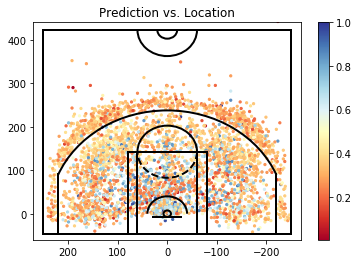

In [52]:
# defining court drawings:
def draw_court(ax = None, color = 'black', lw = 2, outer_lines = False):
	# If an axes object isn't provided to plot onto, just get current one
	if ax is None:
		ax = plt.gca()
	
	# Create the various parts of an NBA basketball court
	
	# Create the basketball hoop
	# Diameter of a hoop is 18" so it has a radius of 9", which is a value
	# 7.5 in our coordinate system
	hoop = Circle((0, 0), radius = 7.5, linewidth = lw, color = color,
	              fill = False)
	
	# Create backboard
	backboard = Rectangle((-30, -7.5), 60, -1, linewidth = lw, color = color)
	
	# The paint
	# Create the outer box 0f the paint, width=16ft, height=19ft
	outer_box = Rectangle((-80, -47.5), 160, 190, linewidth = lw, 
                          color = color, fill = False)
	# Create the inner box of the paint, widt=12ft, height=19ft
	inner_box = Rectangle((-60, -47.5), 120, 190, linewidth = lw, 
                          color = color, fill = False)
	
	# Create free throw top arc
	top_free_throw = Arc((0, 142.5), 120, 120, theta1 = 0, theta2 = 180,
	                     linewidth = lw, color = color, fill = False)
	# Create free throw bottom arc
	bottom_free_throw = Arc((0, 142.5), 120, 120, theta1 = 180, theta2 = 0,
	                        linewidth = lw, color = color, linestyle =
	                        'dashed')
	# Restricted Zone, it is an arc with 4ft radius from center of the hoop
	restricted = Arc((0, 0), 80, 80, theta1 = 0, theta2 = 180, linewidth = lw,
	                 color = color)
	
	# Three point line
	# Create the side 3pt lines, they are 14ft long before they begin to arc
	corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth = lw,
	                           color = color)
	corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth = lw,
	                           color = color)
	# 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
	# I just played around with the theta values until they lined up with the
	# threes
	three_arc = Arc((0, 0), 475, 475, theta1 = 22, theta2 = 158, 
                    linewidth = lw, color = color)
	
	# Center Court
	center_outer_arc = Arc((0, 422.5), 120, 120, theta1 = 180, theta2 = 0,
	                       linewidth = lw, color = color)
	center_inner_arc = Arc((0, 422.5), 40, 40, theta1 = 180, theta2 = 0,
	                       linewidth = lw, color = color)
	
	# List of the court elements to be plotted onto the axes
	court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
	                  bottom_free_throw, restricted, corner_three_a,
	                  corner_three_b, three_arc, center_outer_arc,
	                  center_inner_arc]
	
	if outer_lines:
		# Draw the half court line, baseline and side out bound lines
		outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth = lw,
		                        color = color, fill = False)
		court_elements.append(outer_lines)
	
	# Add the court elements onto the axes
	for element in court_elements:
		ax.add_patch(element)
	
	return ax

# scatter shots
plt.figure()
draw_court(outer_lines = True)
plt.ylim(-60, 440)
plt.xlim(270, -270)
plt.title('Prediction vs. Location')
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(x = evaldata['loc_x'], 
                 y = evaldata['loc_y'],
                 c = evaldata['shot_made_flag'], 
                 s = 5, cmap = cm, alpha = 1)
plt.colorbar(sc)

plt.show()